In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.data.exercise_data import ExerciseDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from src.models.lstm import ExerciseLSTM
import matplotlib.pyplot as plt

In [23]:
X = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\landmarks_data.npy', allow_pickle=True)
y = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\labels_data.npy',    allow_pickle=True)

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

if y.ndim == 2 and y.shape[1] == 1:
    y = y.reshape(-1)
    
print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

Loaded X shape: (761, 300, 132)
Loaded y shape: (761, 1)
Loaded X shape: (761, 300, 132)
Loaded y shape: (761,)


In [24]:
labels_to_keep = [0, 1, 4, 7, 9]
mask = np.isin(y, labels_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Filtered X shape: {X_filtered.shape}")
print(f"Filtered y shape: {y_filtered.shape}")
print(f"Unique labels in filtered data: {np.unique(y_filtered)}")


Filtered X shape: (227, 300, 132)
Filtered y shape: (227,)
Unique labels in filtered data: [0 1 4 7 9]


In [25]:
label_mapping = {original_label: new_label for new_label, original_label in enumerate(labels_to_keep)}
y_mapped = np.array([label_mapping[label] for label in y_filtered], dtype=np.int64)
print(f"Mapped labels: {np.unique(y_mapped)}")

Mapped labels: [0 1 2 3 4]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped)

train_dataset = ExerciseDataset(X_train, y_train)
test_dataset = ExerciseDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [27]:
sequence_length = 300
input_size = 132
hidden_size = 512
num_layers = 1
num_classes = len(labels_to_keep)

model = ExerciseLSTM(input_size, hidden_size, num_layers, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [28]:
num_epochs = 30  # Adjust based on your needs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for sequences, labels in train_loader:
        sequences = sequences.to(device, non_blocking=True)  # Shape: (batch_size, seq_length, input_size)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for sequences, labels in test_loader:
            sequences = sequences.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# ---------------------- Save the Model ----------------------

torch.save(model.state_dict(), 'lstm_v3.pth')
print("Model saved to 'lstm_v381204\
 .pth'")

Epoch [1/30], Loss: 1.4615, Test Accuracy: 45.65%
Epoch [2/30], Loss: 1.0892, Test Accuracy: 58.70%
Epoch [3/30], Loss: 0.8359, Test Accuracy: 65.22%
Epoch [4/30], Loss: 0.8761, Test Accuracy: 56.52%
Epoch [5/30], Loss: 0.7719, Test Accuracy: 67.39%
Epoch [6/30], Loss: 0.7961, Test Accuracy: 63.04%
Epoch [7/30], Loss: 0.6872, Test Accuracy: 73.91%
Epoch [8/30], Loss: 0.6207, Test Accuracy: 78.26%
Epoch [9/30], Loss: 0.5734, Test Accuracy: 80.43%
Epoch [10/30], Loss: 0.5630, Test Accuracy: 71.74%
Epoch [11/30], Loss: 0.5961, Test Accuracy: 76.09%
Epoch [12/30], Loss: 0.4760, Test Accuracy: 78.26%
Epoch [13/30], Loss: 0.3303, Test Accuracy: 86.96%
Epoch [14/30], Loss: 0.4530, Test Accuracy: 78.26%
Epoch [15/30], Loss: 0.4674, Test Accuracy: 80.43%
Epoch [16/30], Loss: 0.5145, Test Accuracy: 82.61%
Epoch [17/30], Loss: 0.6885, Test Accuracy: 36.96%
Epoch [18/30], Loss: 1.2835, Test Accuracy: 63.04%
Epoch [19/30], Loss: 0.9678, Test Accuracy: 76.09%
Epoch [20/30], Loss: 0.7719, Test Accura

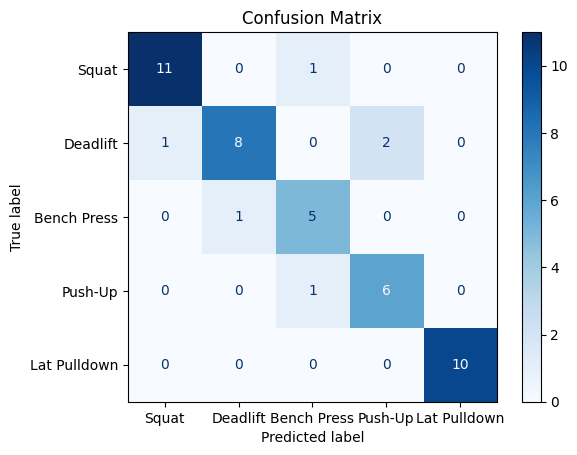

In [29]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append to lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# ---------------------- Plot Confusion Matrix ----------------------

# Assuming the label mapping is as follows
# Original labels: 0, 1, 4, 7, 9
# Mapped labels:   0, 1, 2, 3, 4
label_mapping = {0: 0, 1: 1, 4: 2, 7: 3, 9: 4}

# Class names corresponding to the mapped labels
class_names = ['Squat', 'Deadlift', 'Bench Press', 'Push-Up', 'Lat Pulldown']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions, target_names=class_names))


              precision    recall  f1-score   support

       Squat       0.92      0.92      0.92        12
    Deadlift       0.89      0.73      0.80        11
 Bench Press       0.71      0.83      0.77         6
     Push-Up       0.75      0.86      0.80         7
Lat Pulldown       1.00      1.00      1.00        10

    accuracy                           0.87        46
   macro avg       0.85      0.87      0.86        46
weighted avg       0.88      0.87      0.87        46

